In [160]:
import os
import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from mllib.model import KerasSurrogate
#from helper_functions.scan_helper_functions import AdjustedRSquared
#from helper_functions.ml_helper_functions import RSquaredSeparated, AdjustedRSquaredSeparated

In [161]:
class AdjustedRSquaredSeparated(tf.keras.losses.Loss):
    '''
    Calculates the adjusted R^2 value for each predicted quantity separately.

    For more details, see:
    https://www.analyticsvidhya.com/blog/2020/07/difference-between-r-squared-and-adjusted-r-squared/
    '''
    def __init__(self, batch_size, number_of_input):
        '''
        Parameters
        ==========
        batch_size: int
            Number of samples in a batch,
            i. e. number of rows of a batch of the X matrix.
        number_of_input: int
            Number of independent variables (=columns) in the problem,
            i. e. number of columns of the X matrix.
        '''
        super().__init__(name='adjusted_r2')
        self._n = batch_size
        self._n_in = number_of_input

    def call(self, y_true, y_pred):
        r2 = RSquaredSeparated().call(y_true, y_pred)

        adjusted_r2 = 1. - (1. - r2) * (self._n - 1.) / (self._n - self._n_in - 1.)

        return adjusted_r2

    @classmethod
    def from_config(cls, config):
        return AdjustedRSquaredSeparated(config['n'], config['n_in'])

    def get_config(self):
        return {
            'n': self._n,
            'n_in': self._n_in,
        }

In [162]:
class RSquaredSeparated(tf.keras.losses.Loss):
    '''
    Calculates the R^2 value for each predicted quantity separately.

    For more details, see:
    https://www.analyticsvidhya.com/blog/2020/07/difference-between-r-squared-and-adjusted-r-squared/
    '''
    def __init__(self):
        super().__init__(name='r2')

    def call(self, y_true, y_pred):
        mean_true = tf.math.reduce_mean(y_true, axis=0)

        total_sum_of_squares = tf.math.reduce_sum(tf.math.squared_difference(y_true, mean_true),
                                                  axis=0)
        
        residual_sum_of_squares = tf.math.reduce_sum(tf.math.squared_difference(y_true, y_pred),
                                                     axis=0)
        r2 = 1. - residual_sum_of_squares / total_sum_of_squares

        return r2

In [163]:
class AdjustedRSquared(tf.keras.losses.Loss):
    '''
    For more details, see:
    https://www.analyticsvidhya.com/blog/2020/07/difference-between-r-squared-and-adjusted-r-squared/
    '''
    def __init__(self, batch_size, number_of_input):
        '''
        Parameters
        ==========
        batch_size: int
            Number of samples in a batch,
            i. e. number of rows of a batch of the X matrix.
        number_of_input: int
            Number of independent variables (=columns) in the problem,
            i. e. number of columns of the X matrix.
        '''
        super().__init__(name='adjusted_r2')
        self._n = batch_size
        self._n_in = number_of_input

    def call(self, y_true, y_pred):
        r2 = RSquared().call(y_true, y_pred)

        adjusted_r2 = 1. - (1. - r2) * (self._n - 1.) / (self._n - self._n_in - 1.)
        adjusted_r2 = tf.math.reduce_mean(adjusted_r2)

        return adjusted_r2

    @classmethod
    def from_config(cls, config):
        return AdjustedRSquared(config['n'], config['n_in'])

    def get_config(self):
        return {
            'n': self._n,
            'n_in': self._n_in,
        }

In [164]:
seed = 1234
tf.random.set_seed(seed)
np.random.seed(seed)

# Config

In [205]:
directory = '/data/project/general/aerosolretriev/'
#test_datafile = directory +'/aerosol_data/raw_data/pre_log_ts-0.2_P11_wl-532/test_dataset.hdf5'

test_datafile = directory +'aerosol_data/dataset_15_08_2022/data/data_train_fw.h5'
#test_datafile = directory +'/aerosol_data/raw_data/pre_log_ts-0.2_P11_wl-532_sc-None_switched/test_dataset.hdf5'

In [218]:
model_name = 'forward_model5'


In [219]:
#model_dir = directory +'/aerosol_results_august_2022/forward_model/version2_trunc/models'
model_dir = directory +'/aerosol_results_21_08_2022/forward_model/version4/models'

In [220]:
#plot_dir = f'../plots/models/{model_name}'
plot_dir = model_dir +'/plots/model'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

In [221]:
model_name

'forward_model5'

# Load the model and the data

In [222]:
custom_objects = {
    'AdjustedRSquared': AdjustedRSquared,
}

kwargs = {
    'custom_objects': custom_objects,
    'compile': False,
}

surr = KerasSurrogate.load(model_dir, model_name, model_kwargs=kwargs)
#import tensorflow as tf
#tf.keras.backend.set_floatx('float32')
#surr = KerasSurrogate.load(model_dir, model_name)

/data/user/boiger_r/python_env/aerosol_mieNN/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.24.1 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [223]:
dir(surr)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_build_surrogate',
 '_fit_model',
 '_load_model',
 '_model',
 '_name',
 '_predict_model',
 '_save_model',
 '_version',
 'details',
 'fit',
 'load',
 'model',
 'name',
 'predict',
 'preprocessor_x',
 'preprocessor_y',
 'save',
 'version']

In [224]:
dvar_test = pd.read_hdf(test_datafile,key = 'dvar')
qoi_test = pd.read_hdf(test_datafile,key = 'qoi')

dvar = pd.read_hdf(datafile, key='dvar')
qoi = pd.read_hdf(datafile, key='qoi')

n_in = dvar.shape[1]

dvar_trainval, dvar_test, qoi_trainval, qoi_test = train_test_split(dvar,
                                                                    qoi,
                                                                    test_size=0.2)
dvar_test.reset_index(drop=True, inplace=True)
qoi_test.reset_index(drop=True, inplace=True)

dvar_trainval.reset_index(drop=True, inplace=True)
qoi_trainval.reset_index(drop=True, inplace=True)

kf = KFold(n_splits=5, random_state=76, shuffle=True)

train_ind, val_ind = next(kf.split(dvar_trainval))

dvar_train = dvar_trainval.values[train_ind]
dvar_val = dvar_trainval.values[val_ind]
qoi_train = qoi_trainval.values[train_ind]
qoi_val = qoi_trainval.values[val_ind]

In [225]:
#surr.evaluate(dvar_test,qoi_test)

In [226]:
dvar_test

F11_0     F11_1     F11_2     F11_3     F11_4     F11_5     F11_6  \
0      4.802033  4.799321  4.791239  4.777931  4.759624  4.736601  4.709181   
1      6.123222  5.262614  4.598672  4.084411  3.658911  3.293258  2.971266   
2      7.440076  7.120689  6.735216  6.391483  6.084878  5.807989  5.555053   
3      5.556438  5.550653  5.533441  5.505220  5.466620  5.418420  5.361480   
4      5.166345  4.894558  4.542436  4.219849  3.928025  3.662140  3.417755   
...         ...       ...       ...       ...       ...       ...       ...   
79995  6.976754  6.818534  6.455844  6.013912  5.550213  5.090401  4.646966   
79996  9.974646  9.967034  9.945748  9.914497  9.877165  9.836398  9.793541   
79997  6.993833  6.988441  6.973000  6.949284  6.919246  6.884455  6.846043   
79998  9.509944  9.432875  9.254977  9.034141  8.797183  8.556288  8.317312   
79999  5.688307  5.486067  5.226292  4.991506  4.779783  4.586782  4.408973   

          F11_7     F11_8     F11_9  ...   PPF_170   PPF_171   PPF_172  \
0      4.677702  4.642508  4.603934  ...  0.013789  0.011318  0.009050   
1      2.682850  2.421254  2.181701  ...  0.006894  0.005773  0.004715   
2      5.321807  5.105063  4.902389  ...  0.010218  0.008364  0.006674   
3      5.296690  5.224928  5.147041  ...  0.011815  0.009933  0.008120   
4      3.191363  2.980246  2.782277  ...  0.010890  0.008946  0.007163   
...         ...       ...       ...  ...       ...       ...       ...   
79995  4.226457  3.832384  3.466433  ...  0.006806  0.005533  0.004390   
79996  9.749305  9.704202  9.658615  ...  0.013476  0.010956  0.008686   
79997  6.804857  6.761552  6.716631  ...  0.019053  0.015521  0.012327   
79998  8.083185  7.855386  7.634635  ...  0.009047  0.007445  0.005973   
79999  4.243694  4.088923  3.943102  ...  0.019702  0.016201  0.012981   

        PPF_173   PPF_174   PPF_175   PPF_176   PPF_177   PPF_178   PPF_179  
0      0.007003  0.005193  0.003635  0.002341  0.001324  0.000590  0.000148  
1      0.003729  0.002825  0.002018  0.001323  0.000758  0.000342  0.000086  
2      0.005158  0.003822  0.002674  0.001722  0.000974  0.000434  0.000109  
3      0.006409  0.004837  0.003438  0.002243  0.001280  0.000575  0.000145  
4      0.005552  0.004125  0.002893  0.001867  0.001057  0.000472  0.000118  
...         ...       ...       ...       ...       ...       ...       ...  
79995  0.003377  0.002494  0.001740  0.001119  0.000632  0.000282  0.000071  
79996  0.006671  0.004914  0.003421  0.002194  0.001236  0.000550  0.000138  
79997  0.009481  0.006993  0.004872  0.003127  0.001763  0.000785  0.000196  
79998  0.004640  0.003455  0.002428  0.001570  0.000891  0.000398  0.000100  
79999  0.010066  0.007479  0.005245  0.003384  0.001916  0.000855  0.000214  

[80000 rows x 360 columns]

In [227]:
dvar_test.columns

Index(['F11_0', 'F11_1', 'F11_2', 'F11_3', 'F11_4', 'F11_5', 'F11_6', 'F11_7',
       'F11_8', 'F11_9',
       ...
       'PPF_170', 'PPF_171', 'PPF_172', 'PPF_173', 'PPF_174', 'PPF_175',
       'PPF_176', 'PPF_177', 'PPF_178', 'PPF_179'],
      dtype='object', length=360)

# Predict

In [228]:
qoi_pred = surr.predict(dvar_test)
qoi_pred = pd.DataFrame(data=qoi_pred, columns=qoi_test.columns)

/data/user/boiger_r/python_env/aerosol_mieNN/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [229]:
qoi_pred.describe()

Vtot      RmedianV           GSD             n             k
count  80000.000000  80000.000000  80000.000000  80000.000000  80000.000000
mean     594.425706   1227.448816      1.975294      2.197830      1.098614
std     1068.561062   1264.938615      0.568308      0.480480      0.634943
min     -559.803114   -267.171867     -0.021234      1.090581     -0.550796
25%       16.907147    256.191527      1.453349      1.772282      0.539775
50%       87.599972    678.220090      1.982620      2.211089      1.100814
75%      581.133149   1845.454529      2.482471      2.621108      1.651924
max     8880.458437   5250.319789      3.064152      4.282233      3.425327

In [204]:
qoi_test.describe()

Vtot      RmedianV           GSD             n             k
count  18000.000000  18000.000000  18000.000000  18000.000000  18000.000000
mean     576.121312   1253.031261      1.996431      2.159699      1.103524
std     1047.387832   1267.232900      0.574952      0.483124      0.632293
min        1.000783    100.008814      1.001019      1.330003      0.000135
25%        8.000351    265.658897      1.501265      1.741477      0.554082
50%       67.106629    717.583799      1.992211      2.157726      1.105678
75%      578.605879   1874.496470      2.498469      2.574063      1.649918
max     4998.395477   4999.474451      2.999704      2.999911      2.199874

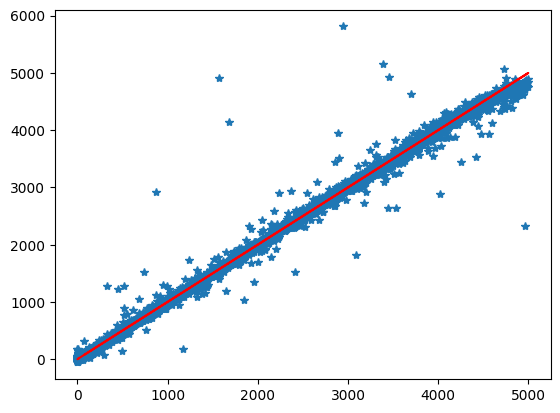

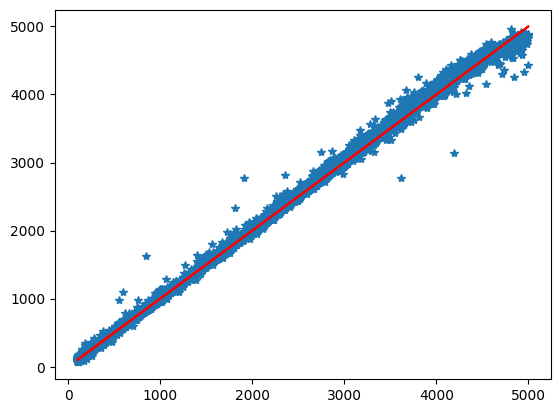

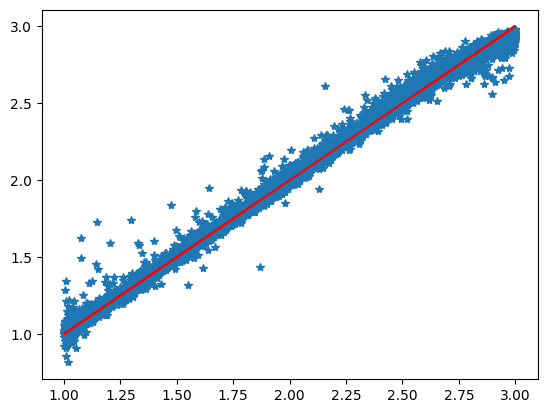

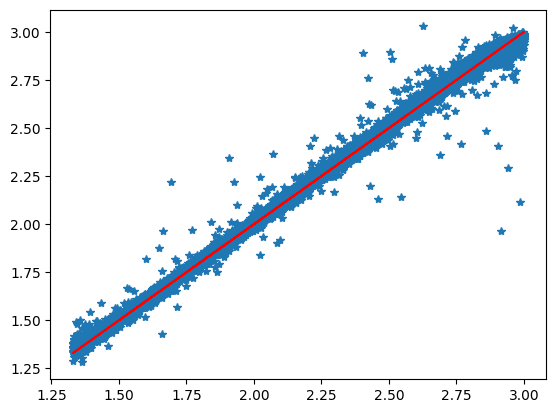

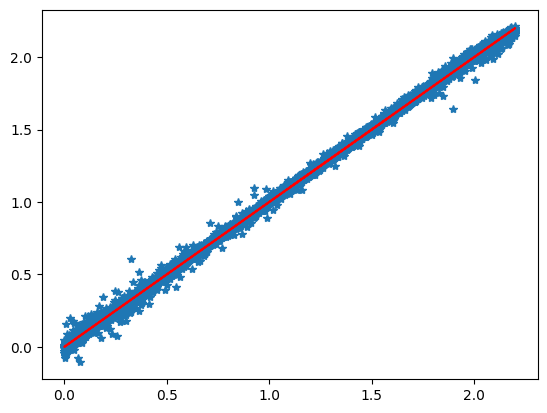

In [107]:

for col in qoi_pred.keys():
    plt.figure()
    plt.plot(qoi_test[col],qoi_pred[col],"*")
    plt.plot(qoi_test[col],qoi_test[col],'r')

In [108]:
# Mean absolute error
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score

In [109]:
for col in qoi_pred.keys():
    MAE = mean_absolute_error(qoi_test[col],qoi_pred[col])
    col_mean = qoi_test[col].mean()
    col_p = MAE / col_mean *100
    print(col,'***',MAE,'***', col_mean,'***',col_p)

Vtot *** 18.974718028065098 *** 576.1213120610701 *** 3.293528225884089
RmedianV *** 25.301598812201618 *** 1253.0312610012975 *** 2.0192312514201047
GSD *** 0.020153990737247753 *** 1.9964306278191026 *** 1.0095011795758682
n *** 0.0194583771143652 *** 2.159699124170475 *** 0.9009762932528401
k *** 0.012926060506431058 *** 1.1035239278693876 *** 1.1713439264871996


In [110]:
for col in qoi_pred.keys():
    RMSE = np.sqrt(mean_squared_error(qoi_test[col],qoi_pred[col]))
    col_mean = qoi_test[col].mean()
    col_p = MAE / col_mean *100
    print(col,'***',MAE,'***', col_mean,'***',col_p)

Vtot *** 0.012926060506431058 *** 576.1213120610701 *** 0.002243635192072337
RmedianV *** 0.012926060506431058 *** 1253.0312610012975 *** 0.0010315832420734533
GSD *** 0.012926060506431058 *** 1.9964306278191026 *** 0.6474585355641165
n *** 0.012926060506431058 *** 2.159699124170475 *** 0.5985120965123263
k *** 0.012926060506431058 *** 1.1035239278693876 *** 1.1713439264871996


In [111]:
for col in qoi_pred.keys():
    EVS = explained_variance_score(qoi_test[col],qoi_pred[col])
    print(col, EVS)

Vtot 0.9960250992047449
RmedianV 0.9988062664967099
GSD 0.9973068305599367
n 0.9968950384041699
k 0.9992862438040752


# Calculate metrics

In [112]:
qoi_test.columns.values

array(['Vtot', 'RmedianV', 'GSD', 'n', 'k'], dtype=object)

In [113]:
res = qoi_test - qoi_pred

q = np.arange(0.1, 1.0, 0.05)
q = np.append(q, [0.98, 0.99])
q = np.round(q, decimals=3)
quantiles = res.abs().quantile(q)
quantiles.to_csv(f'{plot_dir}/forward_prediction_residual_quantiles_by_longitudinal_pos.csv', sep='\t')

In [114]:
metric = AdjustedRSquaredSeparated(dvar_test.shape[0], dvar_test.shape[1])

r2_adj = metric.call(qoi_test.values, qoi_pred.values).numpy()
r2_adj = pd.Series(data=r2_adj, index=qoi_test.columns)
r2_adj = np.round(r2_adj, decimals=2)
r2_adj = pd.DataFrame(r2_adj).T

In [115]:
r2_adj = pd.DataFrame(r2_adj)

In [116]:
r2_adj

Vtot  RmedianV  GSD    n    k
0   1.0       1.0  1.0  1.0  1.0

In [117]:
min(r2_adj.min())

1.0

In [118]:
qoi_test.describe()

Vtot      RmedianV           GSD             n             k
count  18000.000000  18000.000000  18000.000000  18000.000000  18000.000000
mean     576.121312   1253.031261      1.996431      2.159699      1.103524
std     1047.387832   1267.232900      0.574952      0.483124      0.632293
min        1.000783    100.008814      1.001019      1.330003      0.000135
25%        8.000351    265.658897      1.501265      1.741477      0.554082
50%       67.106629    717.583799      1.992211      2.157726      1.105678
75%      578.605879   1874.496470      2.498469      2.574063      1.649918
max     4998.395477   4999.474451      2.999704      2.999911      2.199874

In [119]:
qoi_pred.describe()

Vtot      RmedianV           GSD             n             k
count  18000.000000  18000.000000  18000.000000  18000.000000  18000.000000
mean     578.948003   1266.641427      2.006540      2.172572      1.109997
std     1045.371780   1278.156414      0.574858      0.484228      0.635579
min      -56.351127     61.852800      0.814450      1.280742     -0.107483
25%       14.818318    270.938012      1.510062      1.752633      0.560182
50%       62.545758    725.697113      2.003535      2.169340      1.111876
75%      585.084215   1894.928516      2.517085      2.594208      1.659828
max     5809.538472   4959.938434      2.985382      3.028249      2.211472

In [82]:
qoi_test = qoi_test.reset_index(drop = True)
qoi_test

Vtot     RmedianV       GSD         n         k
0         9.782479   740.955994  1.860629  1.509454  1.576845
1         4.953045   447.099789  1.687354  2.622790  0.754203
2         9.853527  2953.110936  2.635387  2.087974  1.787399
3        27.700011   254.587570  1.044152  2.913697  1.101197
4        49.011526   519.446422  2.185569  2.364048  2.055679
...            ...          ...       ...       ...       ...
17995  2902.889066   244.818462  2.048755  1.459021  0.468698
17996     3.793219   204.348275  1.206468  1.562014  1.081841
17997     8.990683   528.078164  1.949690  2.689447  1.873984
17998  2367.063858   780.091790  2.555797  2.806807  0.538075
17999    84.401659   168.632644  2.579873  2.563342  1.104086

[18000 rows x 5 columns]

In [83]:
error = qoi_pred - qoi_test
error

Vtot   RmedianV       GSD         n         k
0       8.174173   3.087242  0.002959 -0.006160 -0.001908
1       1.560552  -7.829780 -0.000937 -0.009626 -0.000282
2      10.103909 -10.047641  0.005909 -0.001269  0.004015
3     -15.293639 -15.151267  0.001588 -0.031901 -0.003398
4      -6.270840 -10.180725  0.001597 -0.006064 -0.006628
...          ...        ...       ...       ...       ...
17995  16.925951 -12.654175 -0.000342 -0.004086  0.001350
17996  -0.929290 -15.669491  0.002275 -0.014544  0.010354
17997   5.566357 -14.678688  0.000841 -0.005767 -0.001485
17998  -5.495957  -4.557209  0.008978  0.000506 -0.009028
17999   4.775775  -5.771237  0.007442 -0.000698 -0.002379

[18000 rows x 5 columns]

In [84]:
rel_error = (qoi_test - qoi_pred) / qoi_test * 100.
rel_error = pd.DataFrame(rel_error, columns=qoi_test.columns).abs()
rel_error.reset_index(drop=True, inplace=True)
rel_error

Vtot  RmedianV       GSD         n         k
0       83.559312  0.416657  0.159007  0.408104  0.120996
1       31.506918  1.751238  0.055548  0.367027  0.037411
2      102.541041  0.340239  0.224228  0.060764  0.224609
3       55.211671  5.951299  0.152039  1.094862  0.308568
4       12.794623  1.959918  0.073048  0.256528  0.322432
...           ...       ...       ...       ...       ...
17995    0.583073  5.168799  0.016707  0.280018  0.288065
17996   24.498729  7.668032  0.188571  0.931089  0.957108
17997   61.912509  2.779643  0.043159  0.214430  0.079239
17998    0.232185  0.584189  0.351288  0.018022  1.677891
17999    5.658390  3.422372  0.288455  0.027237  0.215489

[18000 rows x 5 columns]

In [85]:
rel_error_table = np.round(rel_error.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)

In [86]:
rel_error_table

Vtot  RmedianV   GSD     n      k
50%     8.80      0.85  0.25  0.22   0.42
75%    79.41      2.14  0.50  0.41   1.08
90%   329.67      4.96  0.94  0.68   3.42
95%   600.00      7.68  1.45  0.97   8.00
99%  1460.34     17.34  3.77  2.24  60.86

In [87]:
rel_error_table

Vtot  RmedianV   GSD     n      k
50%     8.80      0.85  0.25  0.22   0.42
75%    79.41      2.14  0.50  0.41   1.08
90%   329.67      4.96  0.94  0.68   3.42
95%   600.00      7.68  1.45  0.97   8.00
99%  1460.34     17.34  3.77  2.24  60.86

In [88]:
rel_error_table.min(axis = 1)

50%    0.22
75%    0.41
90%    0.68
95%    0.97
99%    2.24
dtype: float64

In [89]:
rel_error_table.max(axis = 1)

50%       8.80
75%      79.41
90%     329.67
95%     600.00
99%    1460.34
dtype: float64

# Save $\bar{R}^2$

In [90]:
#r2_adj.to_latex(f'{plot_dir}/r2_table.tex', index=False, escape=False)

In [91]:
r2_adj_T = r2_adj.T
r2_adj_T=r2_adj_T.rename(columns={0: "r2_adj"})
r2_adj_T

r2_adj
Vtot         1.0
RmedianV     1.0
GSD          1.0
n            1.0
k            1.0

# Plot

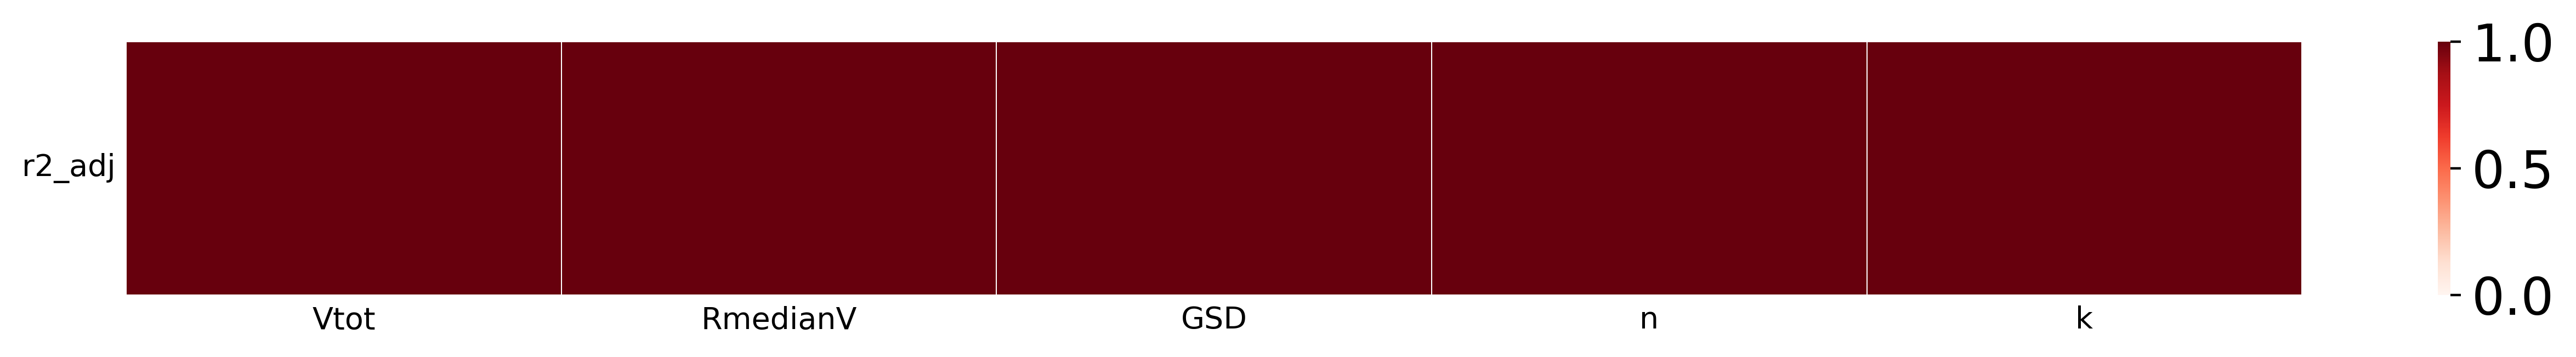

In [92]:
fig, ax = plt.subplots(figsize=(16, 1.5), dpi=400)

sns.heatmap(pd.DataFrame(r2_adj_T, columns = ['r2_adj']).T,
            cmap='Reds',
       #     annot=False,
            linewidths=0.01,
            vmin=0.,
            vmax=1.,
      #      annot_kws={'fontsize': 20},
#            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'},
            ax=ax)
ax.tick_params(labelsize=10, length=0)
ax.tick_params(axis='y', rotation=0)
#ax.xaxis.tick_top()

# adjust the size of the colorbar label
fig.axes[1].set_ylabel(fig.axes[1].get_ylabel(), fontsize=30);
fig.axes[1].tick_params(labelsize=17)

#fig.tight_layout(rect=(0, 0, 1.05, 1))
fig.savefig(f'{plot_dir}/forward_model_r2_adj.jpg')


## Relative Errors

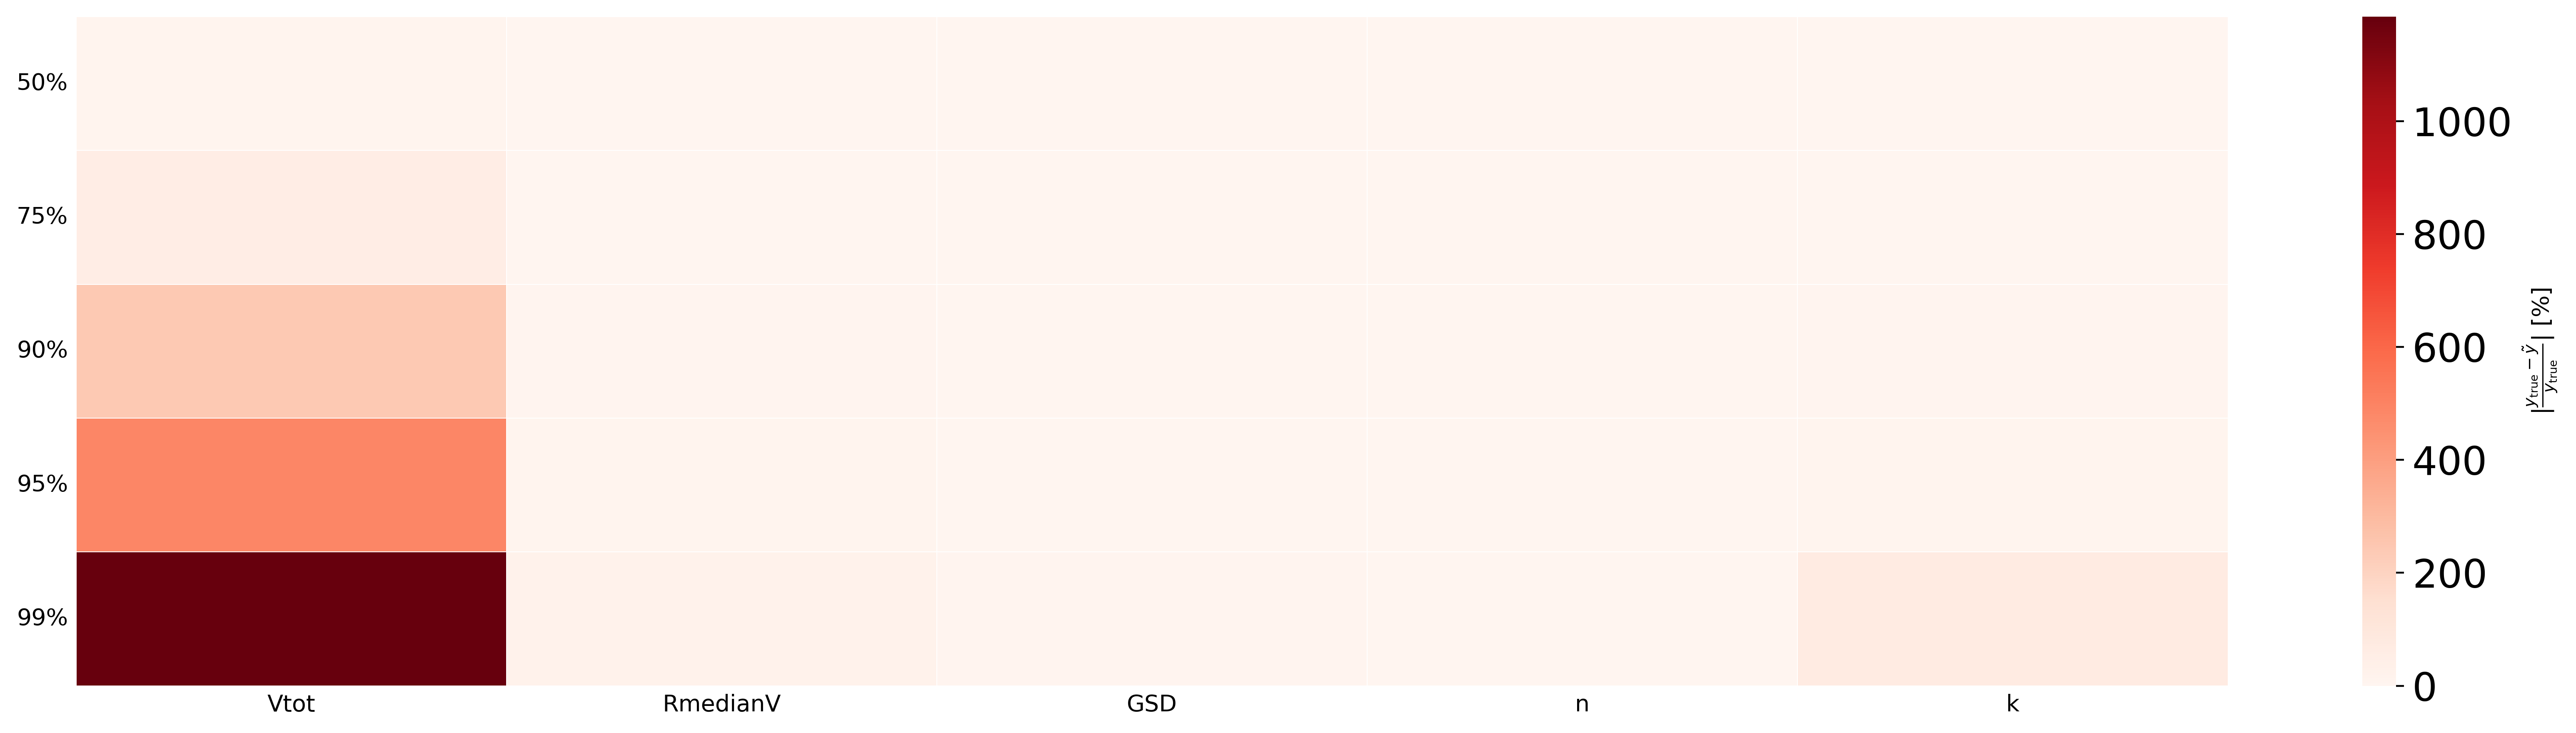

In [53]:
fig, ax = plt.subplots(figsize=(16, 4.5), dpi=400)

sns.heatmap(rel_error_table,
            cmap='Reds',
            #annot=True,
            linewidths=0.02,
            vmin=0.,
            vmax=np.max(rel_error_table.max()),
            #annot_kws={'fontsize': 10},
            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'},
            ax=ax)
ax.tick_params(labelsize=10, length=0)
ax.tick_params(axis='y', rotation=0)
#ax.xaxis.tick_top()

# adjust the size of the colorbar label
fig.axes[1].set_ylabel(fig.axes[1].get_ylabel(), fontsize=10);
fig.axes[1].tick_params(labelsize=17)

fig.tight_layout(rect=(0, 0, 1.05, 1))
fig.savefig(f'{plot_dir}/isodar_forward_rel_error_percentiles.jpg')

## DVARs vs. percentage errors

In [54]:
def plot_error_vs_dvar(design_var):
    fig, axes = plt.subplots(4, 3, figsize=(16, 27))


    for i, col in enumerate(qoi_test.columns[0:12]):
        ax = axes.flatten()[i]

        ax.plot(dvar_test[design_var],
                rel_error[col],
                'o');

        ax.hlines(y=0.,
                  xmin=dvar_test[design_var].min(),
                  xmax=dvar_test[design_var].max(),
                  color='red',
                  zorder=3)

        ax.set_xlabel(design_var, fontsize=20)
        ax.set_ylabel(r'$\Delta$' + col + r' [%]', fontsize=20)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        

    fig.tight_layout()
    fig.savefig(f'{plot_dir}/percentage_error_vs_{design_var}.jpg')
    
    return fig

In [55]:
qoi_test.columns[0:11]

Index(['Vtot', 'RmedianV', 'GSD', 'n', 'k'], dtype='object')

In [56]:
qoi_pred[qoi_pred['Vtot']<0]

Vtot     RmedianV       GSD         n         k
30    -1.120938  1188.098844  1.298592  1.711967  0.837517
36    -8.515091   301.879517  2.182718  1.717358  1.618646
59    -0.501192   339.544008  1.351685  1.586045  1.648477
76    -0.786570  2014.595778  2.341679  2.332640  0.466968
108   -4.304426  1294.834702  1.775265  1.439048  0.820629
...         ...          ...       ...       ...       ...
17883 -0.844473  3997.846095  1.606779  1.683883  2.120825
17891 -3.239405   110.709084  1.040464  2.541604  0.891652
17928 -3.160052   284.569193  1.230952  2.391992  1.735240
17941 -1.452706  2669.929751  1.382820  1.483833  1.001028
17996 -6.385918   215.762236  1.219138  1.577337  1.097263

[939 rows x 5 columns]

In [57]:
for d in dvar_test.columns:
    plot_error_vs_dvar(d)

/tmp/ipykernel_88791/4002909267.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(4, 3, figsize=(16, 27))
Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x2b2d6476b0d0>
Traceback (most recent call last):
  File "/psi/home/boiger_r/.local/lib/python3.9/site-packages/matplotlib/transforms.py", line 222, in <lambda>
    self, lambda _, pop=child._parents.pop, k=id(self): pop(k))
KeyboardInterrupt: 


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x2b2c8863fee0> (for post_execute):


KeyboardInterrupt: 

## Correlations between DVARs and QOIs

In [ ]:
combined = pd.concat([dvar_test, rel_error], axis=1)

In [ ]:
corr = np.round(combined.corr(), decimals=2)

In [ ]:
to_plot = corr.copy()
to_plot.drop(columns=dvar_test.columns, inplace=True)
#to_plot.rename(columns=qoi.columns, index=qoi.columns.values, inplace=True)

In [ ]:
qoi_test.columns

In [ ]:
to_plot = to_plot.drop(qoi_test.columns, axis =0)

In [ ]:
to_plot

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))

sns.heatmap(to_plot,
            vmin=-1.,
            vmax=1.,
            cmap='coolwarm',
            linewidths=0.01,
           # annot=True,
            ax=ax)
ax.tick_params(axis='y', rotation=0)
ax.tick_params(axis='both', length=0, labelsize=10)

fig.tight_layout()
fig.savefig(f'{plot_dir}/rel_error_correlations.jpg')

## Residuals

In [ ]:
error


In [ ]:
colors = sns.color_palette()

fig, ax = plt.subplots(figsize=(16, 9))
for col in qoi_test.columns[0:3]:
    sns.distplot(error[col], ax=ax)
ax.text(x=-0.025,
        y=5,
        color=colors[0],
        s=r'$phase_0.0$',
        fontsize=30)
ax.text(x=0.015,
        y=3,
        color=colors[1],
        s=r'$phase_1.0$',
        fontsize=30)
ax.text(x=0.01,
        y=4,
        color=colors[2],
        s=r'$phase_2.0$',
        fontsize=30)
ax.set_xlabel('Residuals [mm]', fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(labelsize=18)

fig.savefig(f'{plot_dir}/residual_distr_sigma.jpg')

colors = sns.color_palette()

fig, ax = plt.subplots(figsize=(16, 9))
for col in qoi.columns:
    sns.distplot(error[col], ax=ax)
#ax.text(x=-0.025,
#        y=15,
#        color=colors[0],
#        s=r'$\sigma_x$',
#        fontsize=30)
#ax.text(x=0.015,
#        y=30,
#        color=colors[1],
#        s=r'$\sigma_y$',
#        fontsize=30)
#ax.text(x=0.01,
#        y=40,
#        color=colors[2],
#        s=r'$\sigma_z$',
#        fontsize=30)
ax.set_xlabel('Residuals [mm]', fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(labelsize=18)

fig.savefig(f'{plot_dir}/residual_distr_sigma.jpg')

In [ ]:
def standardise(x):
    return (x - x.mean()) / x.std()

In [ ]:
for i, col in enumerate(qoi_test.columns[0:11]):
    print(i)
    print(col)

In [ ]:
fig, axes= plt.subplots(4, 3, figsize=(16, 9))

for i, col in enumerate(qoi_test.columns[0:12]):
    ax = axes.flatten()[i]
    scipy.stats.probplot(standardise(error[col]), dist="norm", plot=ax);
#    ax.set_title(qoi.columns[col], fontsize=20)
    ax.set_ylabel('Quantiles of\n standardised residuals')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True)
    ax.grid(True, which='minor')
    #ax.set_yticks([-3, -2, -1, 0, 1, 2, 3])
    ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

fig.tight_layout()
fig.savefig(f'{plot_dir}/residual_normality_plots.jpg')

In [ ]:
# pd.DataFrame({'Mean': error.mean(axis=0), 'std': error.std(axis=0)})

In [ ]:
rel_error.abs().quantile(0.9)

In [ ]:
qoi_columns = qoi_test.columns

In [ ]:
statistic, p = scipy.stats.shapiro(standardise(error[qoi_test.columns[0]]).values)

In [ ]:
statistic

In [ ]:
p

In [ ]:
surr.model.summary()

In [ ]:
qoi_pred

In [ ]:
test_index = qoi_test.index.tolist()
test_index

In [ ]:
presentation_plot_index = [0,1,3,4,5,6]

qoi_test.index.values

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
for index in qoi_test.index.values:
    ax.plot(np.arange(3,len(qoi_test.columns)+3),qoi_test.iloc[index],'b*')
    ax.plot(np.arange(3,len(qoi_pred.columns)+3),qoi_pred.iloc[index],'r.')
    
    #plt.yscale('logit')

ax.set_xlabel('Scattering angle (degrees)',fontsize = 25)
ax.set_ylabel('P11[$m^{-1}sr^{-1}$]',fontsize = 25)
ax.tick_params(labelsize = 16)    
fig.tight_layout() 
ax.set_title('GSD=1.5, RI_n=1.5, RI_k=0.005',fontsize = 25)
#fig.align_labels()
ax.legend(loc='upper right', shadow=True,title='GMD', fontsize=16)
ax.get_legend().get_title().set_fontsize('16')
fig.savefig(f'{plot_dir}/phase_data__result_all.jpg')

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
for index in presentation_plot_index:
    plot_test_data = ax.plot(np.arange(3,len(qoi_test.columns)+3),qoi_test.iloc[index],'b*')
    plot_pred_data = ax.plot(np.arange(3,len(qoi_pred.columns)+3),qoi_pred.iloc[index],'r.')
    
    #plt.yscale('logit')

ax.set_xlabel('Scattering angle (degrees)',fontsize = 25)
ax.set_ylabel('P11[$m^{-1}sr^{-1}$]',fontsize = 25)
ax.tick_params(labelsize = 16)    
fig.tight_layout() 
ax.set_title( 'Comparison Test and Prediction',fontsize = 25)
#fig.align_labels()
ax.legend(['Test data', 'Predicted test data'], fontsize = 16)
#ax.legend(loc='upper right', shadow=True,title='GMD', fontsize=16)
ax.get_legend().get_title().set_fontsize('16')
fig.savefig(f'{plot_dir}/phase_data__result.jpg')

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
for index in qoi_test.index.values:
    ax.plot(qoi_test.iloc[index],qoi_pred.iloc[index],'b*')
    
    #plt.yscale('logit')
    
    
ax.set_xlabel('Test data',fontsize = 25)
ax.set_ylabel('Predicted test data ',fontsize = 25)
ax.tick_params(labelsize = 16)    
fig.tight_layout() 

ax.axline([-25, -25], [-8, -8])


#fig.align_labels()
#ax.get_legend().get_title().set_fontsize('16')
fig.savefig(f'{plot_dir}/phase_data_correlation.jpg')

In [ ]:
from keras.utils.vis_utils import plot_model

In [ ]:
plot_dir

In [ ]:
plot_model(surr.model, show_shapes=True,show_layer_names=True, to_file = f'{plot_dir}/model_architecture.png')


In [ ]:
# Plot figure with subplots of different sizes
fig = plt.figure(1)
# set up subplot grid
gridspec.GridSpec(7,3)

plt.subplot2grid((7,3), (0,0), colspan=3, rowspan=1)
sns.heatmap(pd.DataFrame(r2_adj_T, columns = ['r2_adj']).T,
            cmap='Reds',
            linewidths=0.01,
            vmin=0.,
            vmax=1.,
            xticklabels= False)
plt.tick_params(labelsize = 16)    
plt.title( 'Adjusted R2',fontsize = 25)

plt.subplot2grid((7,3), (1,0), colspan =3, rowspan =1)
sns.heatmap(rel_error_table,
            cmap='Reds',
            linewidths=0.01,
            vmin=0.,
            vmax=np.max(rel_error_table.max()),
            xticklabels = False,
            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'})
plt.tick_params(labelsize = 16)    
plt.title( 'Relative Error',fontsize = 25)


plt.subplot2grid((7,3), (2,0),colspan = 3, rowspan = 2)
sns.heatmap(to_plot,
            vmin=-1.,
            vmax=1.,
            linewidths = 0.01,
            cmap='coolwarm',)
plt.tick_params(labelsize = 16)
plt.title( 'Correlation between DVARs and QOIs',fontsize = 25)

plt.subplot2grid((7,3), (5,0), colspan = 2, rowspan = 2)
for index in presentation_plot_index:
    plot_test_data = plt.plot(np.arange(3,len(qoi_test.columns)+3),qoi_test.iloc[index],'b*')
    plot_pred_data = plt.plot(np.arange(3,len(qoi_pred.columns)+3),qoi_pred.iloc[index],'r.')
plt.xlabel('Scattering angle (degrees)',fontsize = 25)
plt.ylabel('P11[$m^{-1}sr^{-1}$]',fontsize = 25)
plt.tick_params(labelsize = 16)    
plt.title( 'Comparison Test and Prediction',fontsize = 25)
#fig.align_labels()
plt.legend(['Test data', 'Predicted test data'], fontsize = 16)
#get_legend().get_title().set_fontsize('16')


plt.subplot2grid((7,3), (5,2), colspan = 1, rowspan = 1)
for index in qoi_test.index.values:
    plt.plot(qoi_test.iloc[index],qoi_pred.iloc[index],'b*')
plt.title( 'Comparison Test and Prediction',fontsize = 25)    
plt.xlabel('Test data',fontsize = 25)
plt.ylabel('Predicted test data ',fontsize = 25)
plt.tick_params(labelsize = 16)    
plt.axline([-25, -25], [-8, -8])


fig.set_size_inches(w=30,h=30)
fig.savefig(f'{plot_dir}/overview_forward_model.jpg')
